<a href="https://colab.research.google.com/github/Intelligence-Engineering-LAB-KU/Seminar/blob/master/summer_2020/intern1/Vanilla_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vanilla RNN 실습
>writer : nemo<br>
>2020-08-10

## Contents
이 글에서는 Vanilla RNN을 numpy로 실습하고, 관련된 내용을 다루고자 한다.

1~3절까지는 Character 단위의 many2many RNN을 구현하고 학습시키는 내용을 다룬다. <br>
[이 블로그](https://ratsgo.github.io/natural%20language%20processing/2017/03/09/rnnlstm/)에 있는 아래의 사진에 있는 RNN을 numpy로 충실히 구현하였다. 구현한 RNN에 셰익스피어의 글을 학습시키고 첫 글자를 주었을 때 100 ~ 200자 정도 되는 글을 작성하게끔 하였다.

<img src="http://i.imgur.com/s8nYcww.png" width="50%" height="50%">

4절부터는 만든 RNN을 갖고 놀고, 그 과정을 적고자 한다. <br>
첫 구현에서는 Initial h_0를 학습하도록 구현했는데, 여러 Initializer와 Optimizer를 이용해 만든 여러 모델에 대해 Initial h_0의 사용 여부에 대한 성능을 측정해보았다.

~~6절은 구현에서 주의할 부분과 PyTorch 구현을 담고자 한다.~~

## 1. Data Preprocessing
실습을 시작하기 전, 기본적인 설정을 하자.

### 1.1. Import
실습에 필요한 모듈을 Import 하자.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import IPython.display as dis
import collections

### 1.2. Get Data
실습을 위한 DataSet을 가져오자. 이 글에서는 Shakespeare의 글을 사용하고자 한다.

In [ ]:
!wget https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt
text = open('shakespeare.txt', 'r').read()

--2020-08-11 04:33:14--  https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.27.80, 172.217.25.80, 216.58.197.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.27.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘shakespeare.txt.4’

shakespeare.txt.4   100%[===================>]   1.06M  2.89MB/s    in 0.4s    

2020-08-11 04:33:15 (2.89 MB/s) - ‘shakespeare.txt.4’ saved [1115394/1115394]



### 1.3. Character Vectorization
문자와 수를 변환하기 위한 딕셔너리와 함수를 작성하자.<br>
c2i는 char을 int에 대응하는 것이고, i2c는 int를 char에 대응한 것이다.

In [ ]:
vocab = sorted(set(text))
print('고유 문자수 {}개\n'.format(len(vocab)))
c2i = {u:i for i, u in enumerate(vocab)}
i2c = {i:u for u, i in c2i.items()}
print('c2i\n{}\n'.format(c2i))
print('i2c\n{}'.format(i2c))

고유 문자수 65개

c2i
{'\n': 0, ' ': 1, '!': 2, '$': 3, '&': 4, "'": 5, ',': 6, '-': 7, '.': 8, '3': 9, ':': 10, ';': 11, '?': 12, 'A': 13, 'B': 14, 'C': 15, 'D': 16, 'E': 17, 'F': 18, 'G': 19, 'H': 20, 'I': 21, 'J': 22, 'K': 23, 'L': 24, 'M': 25, 'N': 26, 'O': 27, 'P': 28, 'Q': 29, 'R': 30, 'S': 31, 'T': 32, 'U': 33, 'V': 34, 'W': 35, 'X': 36, 'Y': 37, 'Z': 38, 'a': 39, 'b': 40, 'c': 41, 'd': 42, 'e': 43, 'f': 44, 'g': 45, 'h': 46, 'i': 47, 'j': 48, 'k': 49, 'l': 50, 'm': 51, 'n': 52, 'o': 53, 'p': 54, 'q': 55, 'r': 56, 's': 57, 't': 58, 'u': 59, 'v': 60, 'w': 61, 'x': 62, 'y': 63, 'z': 64}

i2c
{0: '\n', 1: ' ', 2: '!', 3: '$', 4: '&', 5: "'", 6: ',', 7: '-', 8: '.', 9: '3', 10: ':', 11: ';', 12: '?', 13: 'A', 14: 'B', 15: 'C', 16: 'D', 17: 'E', 18: 'F', 19: 'G', 20: 'H', 21: 'I', 22: 'J', 23: 'K', 24: 'L', 25: 'M', 26: 'N', 27: 'O', 28: 'P', 29: 'Q', 30: 'R', 31: 'S', 32: 'T', 33: 'U', 34: 'V', 35: 'W', 36: 'X', 37: 'Y', 38: 'Z', 39: 'a', 40: 'b', 41: 'c', 42: 'd', 43: 'e', 44: 'f', 45: '

이건 numpy array에서 char과 int를 변환하는 함수이다.<br>

In [ ]:
def char2int(a):
    return c2i[a]
char2int_vec = np.vectorize(char2int)

def int2char(a):
    return i2c[a]
int2char_vec = np.vectorize(int2char)

### 1.4. Data Prerocessing

#### 1.4.1. Numpy Array
text를 숫자로 변환하고, 이를 numpy array로 만들자.

In [ ]:
t2i = [c2i[i] for i in text]
ntext = np.array(t2i)
print(ntext[:20])

[18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56]


#### 1.4.2. X와 Y 만들기
Y는 다음 문자를 나타내는 배열로 X를 옆으로 한 칸 밀어서 만들었다.

In [ ]:
X = ntext[:-1]
Y = ntext[1:]

print(X[:20])
print(Y[:20])

[18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56]
[47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56 43]


데이터의 크기를 보자

In [ ]:
print(X.shape[0])

1115393


#### 1.4.3. Train data / Test data 나누기
800000개는 train data로 사용하고 나머지는 test data로 사용하자.

In [ ]:
X_train = X[:800000]
Y_train = Y[:800000]

X_test = X[800000:]
Y_test = Y[800000:]

## 2. Class와 함수 구현
Initializer와 Optimizer와 RNN을 수행하는 Class 구현체를 작성하자.

### 2.1. Initializer
2d numpy array를 위한 Initializer이다.
INITIALIZER()로 선언하거나 상속시켜 다음과 같은 함수를 사용할 수 있다.

> basic(hang, ryeol)

행과 열의 길이를 입력받은 후, 해당 사이즈의 표준 정규분포로 생성한 가중치를 가지는 numpy array를 반환한다.

> Xavier(hang, ryeol)

행과 열의 길이를 입력받은 후, 해당 사이즈의 Xavier Normal Initialization 방법으로 생성한 가중치를 가지는 numpy array를 반환한다.
해당 방법의 공식은 다음과 같다.

$W \sim N(0, Var(W))$<br>
$Var(W)=\sqrt{\frac{2}{n_{in}+n_{out}}}$

In [ ]:
class INITIALIZER:

    def basic(self, hang, ryeol, scale = 0.01):

        return np.random.randn(hang, ryeol) * scale
    
    def Xavier(self, hang, ryeol):

        return np.random.normal(size=(hang, ryeol), scale=(np.sqrt(2 / (hang + ryeol))))

### 2.2. Optimizer
Gradient값을 받아 원래의 변수에서 얼마를 빼주어야할지 결정하는 Optimizer이다.
Optimizer()로 선언하거나 상속시켜 다음과 같은 함수를 사용할 수 있다.

> SGD(dvalue)

dvalue에 leaerning_rate를 곱한 값을 반환한다.

> AdaGrad(key, value, dvalue)

AdaGrad를 수행한 값을 반환한다.
각 변수마다 m값을 저장해야해서 key 인자를 주어야 한다.

In [ ]:
class OPTIMIZER:

    def __init__(self):

        self.param = {}

    def SGD(self, dvalue, learning_rate = 0.01):

        np.clip(dvalue, -5, 5, out=dvalue)

        return dvalue * learning_rate

    def adagrad(self, key, dvalue, learning_rate = 0.01):
        
        np.clip(dvalue, -5, 5, out=dvalue)

        if key not in self.param:
            self.param.setdefault(key + "_m", np.zeros_like(dvalue))

        self.param[key+"_m"] += dvalue * dvalue

        return dvalue * learning_rate / np.sqrt(self.param[key+"_m"] + 1e-8)

### 2.3. Softmax

In [ ]:
class SOFTMAX:

    def __init__(self):

        pass

    def softmax(self, x):

        probs = np.exp(x - np.max(x, axis=-1, keepdims=True))
        probs /= np.sum(probs, axis=-1, keepdims=True)

        return probs

    def loss(self, x, y, batch_size):

        probs = self.softmax(x)
        N = x.shape[0]
        loss = - np.sum(np.log(probs[np.arange(N), y])) / N
        dx = probs.copy()
        dx[np.arange(N), y] -= 1
        dx /= batch_size

        return loss, dx

### 2.4. RNN
Character 단위의 many2many RNN Class이다.<br>
rnn = RNN()으로 선언한 이후 다음과 같은 함수를 사용할 수 있다.

> train(X, Y):

두 numpy 1D array인 X와 Y를 받는다.<br>
X의 원소는 int64이며 Y는 X를 옆으로 한 칸 민 형태이다.<br>
수행 이후 self.history_loss에 loss를 저장한다.

선택적으로 vocab_size와 h_size를 입력할 수도 있으며, 선택하지 않는 경우 h_size의 기본값은 2*vocab_size이다.<br>
init_rule, update_rule, iter, show 등의 인자도 줄 수 있으며<br>
show = "True"라는 인자를 주면 학습 현황(loss, generator)을 실시간으로 보여준다.

> generator(x, length):

train이 끝난 이후 유의미하게 동작한다.<br>
두 수 x와 length를 입력받는다.<br>
x로 시작하며, 추가로 붙인 길이가 length인 문자열을 반환한다.

In [ ]:
class RNN(INITIALIZER, OPTIMIZER, SOFTMAX):

    def __init__(self, vocab_size=1, h_size=1, rule = "basic"):
        
        INITIALIZER.__init__(self)
        OPTIMIZER.__init__(self)

        self.vocab_size = vocab_size
        self.h_size = h_size

        if rule == "basic":

            self.Whh = self.basic(h_size, h_size)
            self.Wxh = self.basic(vocab_size, h_size)
            self.Why = self.basic(h_size, vocab_size)

        elif rule == "Xavier":

            self.Whh = self.Xavier(h_size, h_size)
            self.Wxh = self.Xavier(vocab_size, h_size)
            self.Why = self.Xavier(h_size, vocab_size)

        self.bh = np.zeros((1, h_size))
        self.by = np.zeros((1, vocab_size))
        self.history_loss = []

    def forward_t(self, x_t, h_t_bef):

        """
        x_t : (N, vocab_size)
        h_t_bef : (N, h_size)
        """

        h_t = np.tanh(h_t_bef.dot(self.Whh) + x_t.dot(self.Wxh) + self.bh)  # (N, h)
        y_t = h_t.dot(self.Why) + self.by  # (N, y_size)

        return y_t, h_t

    def forward(self, X, h_0 = None):

        """
        X : (time, N, vocab_size)
        h_0 : (N, h_size)
        """

        time = X.shape[0]
        N = X.shape[1]

        if h_0 is None:
            h_0 = np.zeros((N, self.h_size))

        y_cache = None
        h_cache = np.array([h_0])  # (time, N, h_size)

        for x_t in X:

            y_t, h_t = self.forward_t(x_t, h_cache[-1])

            if y_cache is None:
                y_cache = np.array([y_t])
            else:
                y_cache = np.append(y_cache, [y_t], axis=0)
            h_cache = np.append(h_cache, [h_t], axis=0)

        return y_cache, h_cache

    def backward_t(self, x_t, h_t, h_bef, dy_t, dh_t):  # 글자 단위 backward

        """
        x_t : (N, vocab_size)
        h_t : (N, h_size)
        h_bef : (N, h_size)
        y_t : (N, vocab_size)
        dy_t : (N, vocab_size)
        dh_t : (N, h_size)
        """

        dWhy = h_t.T.dot(dy_t)
        dby = dy_t.sum(axis=0)
        dh_t += dy_t.dot(self.Why.T)

        dWhh = h_bef.T.dot(dh_t * (1 - h_t ** 2))
        dWxh = x_t.T.dot(dh_t * (1 - h_t ** 2))
        dh_bef = (dh_t * (1 - h_t ** 2)).dot(self.Whh.T)
        dbh = (dh_t * (1 - h_t ** 2)).sum(axis=0)

        return dWhh, dWxh, dbh, dWhy, dby, dh_bef

    def backward(self, X, dy, h_cache):

        dy = np.flip(dy, axis=0)
        h_cache = np.flip(h_cache, axis=0)

        """
        dy : (time(t ~ 1), N, y_size)
        y_cache : (time(t ~ 1), N, y_size)
        h_cahce : (time(t ~ 0), N, h_size)
        """

        dWhh = np.zeros_like(self.Whh)
        dWxh = np.zeros_like(self.Wxh)
        dbh = np.zeros_like(self.bh)
        dWhy = np.zeros_like(self.Why)
        dby = np.zeros_like(self.by)
        dh_t = np.zeros((h_cache.shape[1], h_cache.shape[2]))

        for x_t in np.flip(X, axis=0):

            dWhh_t, dWxh_t, dbh_t, dWhy_t, dby_t, dh_t = self.backward_t(x_t, h_cache[0], h_cache[1], dy[0], dh_t)

            # Update
            dWhh += dWhh_t
            dWxh += dWxh_t
            dbh += dbh_t
            dWhy += dWhy_t
            dby += dby_t

            # stack pop
            dy = np.delete(dy, (0), axis=0)
            h_cache = np.delete(h_cache, (0), axis=0)

        dh_0 = dh_t

        return dWhh, dWxh, dbh, dWhy, dby

    def update(self, dWhh, dWxh, dbh, dWhy, dby, rule = "SGD"):
        
        if rule == "SGD":

            self.Whh -= self.SGD(dWhh)
            self.Wxh -= self.SGD(dWxh)
            self.bh -= self.SGD(dbh)
            self.Why -= self.SGD(dWhy)
            self.by -= self.SGD(dby)

        elif rule == "adagrad":

            self.Whh -= self.adagrad("Whh", dWhh)
            self.Wxh -= self.adagrad("Wxh", dWxh)
            self.bh -= self.adagrad("bh", dbh)
            self.Why -= self.adagrad("Why", dWhy)
            self.by -= self.adagrad("by", dby)

    def generator(self, x, length):

        temperature = 1
        start_idx = x
        vector = np.array(start_idx).reshape(1, -1)
        gen_chars = [i2c[start_idx]]
        h = np.zeros((1, self.h_size))

        for _ in range(length):

            vector_one_hot_encoding = np.zeros((1, 1, self.vocab_size))
            vector_one_hot_encoding[0, 0, vector.reshape(-1)] = 1

            y, h = self.forward(vector_one_hot_encoding, h)  # y : (t, N, x_size)
            y = y.reshape(-1, self.vocab_size)
            probs = self.softmax(y)
            probs /= temperature
            next_char = np.random.choice(range(self.vocab_size), p=probs.reshape(-1))
            vector = np.array(next_char).reshape(-1, 1)
            h = h[-1]
            gen_chars.append(i2c[next_char])

        return ''.join(gen_chars)

    def train(self, X_train, Y_train, vocab_size = None, h_size = None, init_rule = "basic", update_rule = "SGD", iter = 1000000, show = True):
        
        if vocab_size == None: vocab_size = len(sorted(set(X_train)))
        if h_size == None: h_size = 2 * vocab_size

        self.__init__(vocab_size, h_size, rule = init_rule)

        seq_length = min(30, max(1, X_train.shape[0] // 2))
        batch_size = min(16, X_train.shape[0])

        for i in tqdm(range(iter)):

            batch_indice = np.random.choice(X_train.shape[0] - seq_length, batch_size)
            X_batch = np.array([X_train[i:i+seq_length] for i in batch_indice])
            Y_batch = np.array([Y_train[i:i+seq_length] for i in batch_indice])

            X_batch = X_batch.T
            X_batch_one_hot_encoding = np.zeros((seq_length, batch_size, self.vocab_size))
            X_batch_one_hot_encoding[np.arange(seq_length * batch_size) // batch_size, np.arange(seq_length * batch_size) % batch_size, X_batch.reshape(-1)] = 1

            y_cache, h_cache = self.forward(X_batch_one_hot_encoding)

            y_cache = y_cache.reshape(seq_length * batch_size, -1)
            Real_Y = Y_batch.T.reshape(seq_length * batch_size)

            loss, dy = self.loss(y_cache, Real_Y, batch_size)
            self.history_loss.append(loss)

            dy = dy.reshape(seq_length, batch_size, -1)
            y_cache = y_cache.reshape(seq_length, batch_size, -1)

            dWhh, dWxh, dbh, dWhy, dby = self.backward(X_batch_one_hot_encoding, dy, h_cache)

            self.update(np.array(dWhh), np.array(dWxh), np.array(dbh), np.array(dWhy), np.array(dby), rule = update_rule)

            if (show == True) and (i % 10000 == 9999):
    
                print('epoch ', i)
                print('loss ', loss)
                print('-----------------------------------')
                gen = self.generator(np.random.randint(0, vocab_size), 200)
                print(self.generator(np.random.randint(0, vocab_size), 200))
                print('-----------------------------------')
                print()

### 2.5. Small Data에 대한 RNN의 동작 확인
잘 돈다.

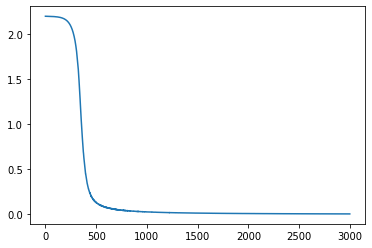

[0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1]


In [ ]:
rnn_small = RNN()
X_small = np.array([0,1,2,3,4,5,6,7,8,0,1,2,3,4,5,6,7,8])
Y_small = np.array([1,2,3,4,5,6,7,8,0,1,2,3,4,5,6,7,8,0])
rnn_small.train(X_small, Y_small, iter = 3000, show = False)

plt.plot(rnn_small.history_loss)
plt.show()
gen_small = rnn_small.generator(0, 10)
print([c2i[i] for i in gen_small])

## 3. Shakespeare에 적용하기


### 3.1. Train
우선 간단하게 Initializer로는 표준 정규분포를, Optimizer로는 Stochastic Gradient Descent를 사용해보자.

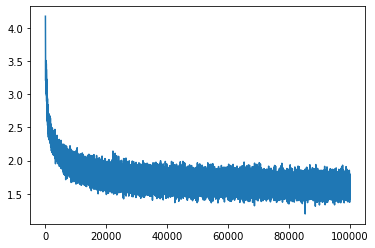

In [ ]:
rnn_shakespeare = RNN()

rnn_shakespeare.train(X_train, Y_train, iter = 100000, show = False)

plt.plot(rnn_shakespeare.history_loss)
plt.show()

학습이 끝난 이후 generator 통해 생성한 글이다. 주인공 이름과 문장의 첫 글자를 대문자로 쓰며, 문장의 끝에 문장부호가 있는 등 학습이 되었음을 확인할 수 있다.

In [ ]:
rnn_shakespeare_writing = rnn_shakespeare.generator(np.random.randint(0, 65), 10000)
print(rnn_shakespeare_writing)

zant: him to the hele?
Stooth goort.

LADUSET:
And see to gold.

HENRY ROHANDY:
March and timent dainy, at the Jagaing their pakes that sach oper.

LADY CARUS:
Lads, have may rishing but now bromerted endoy sthe brain met's his sorted:
should have cafering.

GLOUCESTER:
Which have shadle neadly
Duke and I fall; know of all thems
say you abus, prounst him net.

CORIOLANUS:
Think to speed-been there,
I be gennery ear, shepre'd his bature.

QUEEN FLONG LIUCURISAR:
You shall deety in lay by the would in there shall hurw greason,
Nunkrough diswared steen thisfass'd his fort,
My gravious lord.

LADY GRENCE:
Rionly pemperous werce in our croangelly dust can our abung and basy hom loan:
For his magerire oum.

TARAS:
He sleeped hieps atcheter, Beword agone, and sour of a sicklow this you the listance my see the pabliine, now More giving, if this boy, but ronly glise pedies.

YORK:
Lay? God prey and actury.
Which let be lead the duty, which to dead!
Many himself?
It deed up not appeach.

Second 

### 3.2. Accurancy (Character)
올바른 문자열을 이용해 forwarding하며, 각각의 y가 다음 문자를 잘 예측하고 있는지 측정해보자.

In [ ]:
def test(rnn, X, Y, vocab_size):

    time = X.shape[0]
    X_one_hot_encoding = np.zeros((time, 1, vocab_size))
    X_one_hot_encoding[np.arange(time), 0, X.reshape(-1)] = 1

    y_cache, h_cache = rnn.forward(X_one_hot_encoding) # t, N, y
    
    return (np.sum(y_cache.reshape(time, -1).argmax(axis=1).reshape(-1) == Y.T.reshape(-1)) / time)

print(test(rnn_shakespeare, X_test[:10000], Y_test[:10000], 65))

0.5124


### 3.3. L1 Distance (Word)
원래 text와 RNN이 생성한 단어들을 관찰해보자.

In [ ]:
text_word = collections.Counter(text[800000:].split())
start_idx = np.random.randint(0, 65)
rnn_shakespeare_writing = rnn_shakespeare.generator(start_idx, 315392)
rnn_shakespeare_word = collections.Counter(rnn_shakespeare_writing.split())
print(text_word)
print(rnn_shakespeare_word)

Counter({'the': 1493, 'I': 1435, 'to': 1130, 'and': 1063, 'a': 900, 'you': 844, 'of': 831, 'my': 674, 'in': 600, 'your': 558, 'is': 556, 'not': 510, 'that': 489, 'be': 470, 'And': 452, 'it': 435, 'with': 427, 'for': 417, 'have': 413, 'as': 348, 'he': 334, 'me': 332, 'this': 331, 'his': 329, 'but': 292, 'thou': 279, 'will': 261, 'her': 259, 'so': 240, 'him': 232, 'VINCENTIO:': 216, 'all': 213, 'shall': 211, 'To': 211, 'by': 201, 'she': 195, 'DUKE': 193, 'are': 190, 'do': 187, 'thy': 184, 'no': 183, 'The': 180, 'if': 174, 'good': 169, 'we': 166, 'That': 159, 'what': 159, 'PETRUCHIO:': 158, 'am': 155, 'But': 153, 'sir,': 153, 'you,': 148, 'would': 146, 'or': 141, 'at': 140, 'was': 136, 'on': 135, 'our': 132, 'from': 129, 'ISABELLA:': 129, 'more': 127, 'know': 123, "I'll": 121, 'As': 120, 'For': 118, 'may': 117, 'A': 112, 'LUCIO:': 111, 'make': 105, 'thee': 104, 'an': 104, 'hath': 104, 'You': 102, 'What': 102, 'must': 101, 'My': 98, 'let': 97, 'If': 94, 'were': 94, 'come': 92, 'one': 91, '

L1 distance를 재보자.

In [ ]:
def dis(counter1, counter2):

    L1 = 0
    for key, value in counter1.items():
        if key not in counter2: L1 += value
        else: L1 += abs(value - counter2[key])
    for key, value in counter2.items():
        if key not in counter1: L1 += value

    return L1

rnn_shakespeare_L1 = dis(text_word, rnn_shakespeare_word)
print(rnn_shakespeare_L1)

54446


### 3.4. Text
실제로 글을 얼마나 잘 쓰는 지 확인하자

In [ ]:
print(rnn_shakespeare_writing[:1000])

ge.

VOLUMNIA NOLANUS:
Pemensent so he is omsmecome of gord.
If the possid them; and, juct of Now; Now you high way 'WIUMBYALAS:
I am it fames, gell nothind to bldees your lance.

LORDUSENIUS:
First thee: showes, Evencess? your worthy sparent harge your shower the country we cannot peagred, proch theing ours?

MERCUTIO:
My prize of man a demenn, I kindss malmmess. Who dreast do dear comeing lown but as stees of badnen shall their Jolant, her day mother of of my still their tere love thiTher
In excusties,
And enish prositchery kell up the colann'd his lested ark ambrand; nurse,
Loufler, my lord, serverse,
Thine or a grace, yous bathir for less it thy dowbroch' delaper of corsen,
Father that I see he the dustire he shale.

LADY ANMER:
Where if lap'.

HENRIOLENUENES:
My poncers; this soon! but co fou this grace me:
Well, and youth look of rimones:
Such, upon thy sign of the subsul it of some on that cannot thines of Lord:
I can oenshining still them to be cursenecy fal in. Qids up it.

Se

## 4. 여러 Initializer & Optimizer 를 이용한 RNN model 생성

### 4.1. Train
좋아보이는 Initializer(Xavier)와 Optimizer(Adagrad)를 사용해 모델을 만들어보자. Xavier와 Adagrad의 사용 여부에 따른 4가지 RNN Model을 훈련시키자.

In [ ]:
rnn_shakespeare_Xavier = RNN()
rnn_shakespeare_adagrad = RNN()
rnn_shakespeare_Xavier_adagrad = RNN()

rnn_shakespeare_Xavier.train(X_train, Y_train, init_rule = "Xavier", iter = 100000, show = False)
rnn_shakespeare_adagrad.train(X_train, Y_train, update_rule = "adagrad", iter = 100000, show = False)
rnn_shakespeare_Xavier_adagrad.train(X_train, Y_train, init_rule = "Xavier", update_rule = "adagrad", iter = 100000, show = False)

### 4.2. Accurancy (Character)
Adagrad을 사용하지 않은 모델이 훨씬 높은 문자 단위의 정확성을 가진다.
Xavier도 사용하지 않으면 미미하게 정확성이 높다.

In [ ]:
print("Basic : ", test(rnn_shakespeare, X_test[:10000], Y_test[:10000], 65))
print("Xavier : ", test(rnn_shakespeare_Xavier, X_test[:10000], Y_test[:10000], 65))
print("adagrad : ", test(rnn_shakespeare_adagrad, X_test[:10000], Y_test[:10000], 65))
print("Xavier + adagrad : ", test(rnn_shakespeare_Xavier_adagrad, X_test[:10000], Y_test[:10000], 65))

Basic :  0.5124
Xavier :  0.5106
adagrad :  0.4618
Xavier + adagrad :  0.461


### 4.3. L1 Distance (Word)
빈도수로 정렬하고 보면 같은 단어가 각각의 모델에서 가지는 순위가 유사함을 볼 수 있다. 한편, 2-30순위 이후의 단어들은 기존 Text보다 RNN들의 단어들의 등장횟수가 낮아졌음을 볼 수 있다. 이상한 단어를 생성한만큼 같은 단어를 생성하는 빈도가 줄어든 것으로 추측된다. AdaGrad를 사용하지 않은 두 모델이 그렇지 않은 두 모델보다 단어의 등장횟수가 꾸준히 높은 것도 관찰할 수 있다.

In [ ]:
rnn_shakespeare_Xavier_writing = rnn_shakespeare_Xavier.generator(start_idx, 315392)
rnn_shakespeare_adagrad_writing = rnn_shakespeare_adagrad.generator(start_idx, 315392)
rnn_shakespeare_Xavier_adagrad_writing = rnn_shakespeare_Xavier_adagrad.generator(start_idx, 315392)

rnn_shakespeare_Xavier_word = collections.Counter(rnn_shakespeare_Xavier_writing.split())
rnn_shakespeare_adagrad_word = collections.Counter(rnn_shakespeare_adagrad_writing.split())
rnn_shakespeare_Xavier_adagrad_word = collections.Counter(rnn_shakespeare_Xavier_adagrad_writing.split())

rnn_shakespeare_Xavier_L1 = dis(text_word, rnn_shakespeare_Xavier_word)
rnn_shakespeare_adagrad_L1 = dis(text_word, rnn_shakespeare_adagrad_word)
rnn_shakespeare_Xavier_adagrad_L1 = dis(text_word, rnn_shakespeare_Xavier_adagrad_word)

print("Text : ", text_word)
print("Basic : ", rnn_shakespeare_L1, rnn_shakespeare_word)
print("Xavier : ", rnn_shakespeare_Xavier_L1, rnn_shakespeare_Xavier_word)
print("adagrad : ", rnn_shakespeare_adagrad_L1, rnn_shakespeare_adagrad_word)
print("Xavier + adagrad : ", rnn_shakespeare_Xavier_adagrad_L1, rnn_shakespeare_Xavier_adagrad_word)

Text :  Counter({'the': 1493, 'I': 1435, 'to': 1130, 'and': 1063, 'a': 900, 'you': 844, 'of': 831, 'my': 674, 'in': 600, 'your': 558, 'is': 556, 'not': 510, 'that': 489, 'be': 470, 'And': 452, 'it': 435, 'with': 427, 'for': 417, 'have': 413, 'as': 348, 'he': 334, 'me': 332, 'this': 331, 'his': 329, 'but': 292, 'thou': 279, 'will': 261, 'her': 259, 'so': 240, 'him': 232, 'VINCENTIO:': 216, 'all': 213, 'shall': 211, 'To': 211, 'by': 201, 'she': 195, 'DUKE': 193, 'are': 190, 'do': 187, 'thy': 184, 'no': 183, 'The': 180, 'if': 174, 'good': 169, 'we': 166, 'That': 159, 'what': 159, 'PETRUCHIO:': 158, 'am': 155, 'But': 153, 'sir,': 153, 'you,': 148, 'would': 146, 'or': 141, 'at': 140, 'was': 136, 'on': 135, 'our': 132, 'from': 129, 'ISABELLA:': 129, 'more': 127, 'know': 123, "I'll": 121, 'As': 120, 'For': 118, 'may': 117, 'A': 112, 'LUCIO:': 111, 'make': 105, 'thee': 104, 'an': 104, 'hath': 104, 'You': 102, 'What': 102, 'must': 101, 'My': 98, 'let': 97, 'If': 94, 'were': 94, 'come': 92, 'one

### 4.4. Loss
그래프를 그려보자.

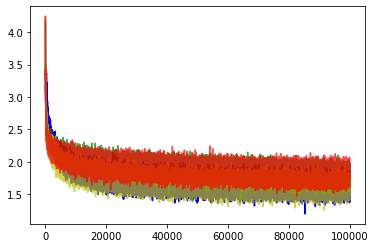

In [ ]:
plt.plot(rnn_shakespeare.history_loss,'b')
plt.plot(rnn_shakespeare_adagrad.history_loss, 'g', alpha=0.7)
plt.plot(rnn_shakespeare_Xavier.history_loss, 'y', alpha=0.7)
plt.plot(rnn_shakespeare_Xavier_adagrad.history_loss, 'r', alpha=0.7)
# 노 파 빨 초

Small Data도 비슷하다. 그러겟지,,?

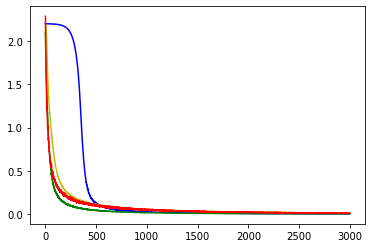

In [ ]:
rnn_small = RNN()
rnn_small2 = RNN()
rnn_small3 = RNN()
rnn_small4 = RNN()
X_small = np.array([0,1,2,3,4,5,6,7,8,0,1,2,3,4,5,6,7,8])
Y_small = np.array([1,2,3,4,5,6,7,8,0,1,2,3,4,5,6,7,8,0])
rnn_small.train(X_small, Y_small, iter = 3000, show = False)
rnn_small2.train(X_small, Y_small, iter = 3000, show = False, init_rule = "Xavier")
rnn_small3.train(X_small, Y_small, iter = 3000, show = False, update_rule = "adagrad")
rnn_small4.train(X_small, Y_small, iter = 3000, show = False, init_rule = "Xavier", update_rule = "adagrad")
plt.plot(rnn_small.history_loss, 'b')
plt.plot(rnn_small2.history_loss,'g')
plt.plot(rnn_small3.history_loss, 'y')
plt.plot(rnn_small4.history_loss, 'r')
plt.show()

### 4.5. Text
각각의 모델이 어떤 글을 쓰는지도 직접 확인해보자.

In [ ]:
print(" ================== Basic ================== \n")
print(rnn_shakespeare_writing[:1000])
print("\n ================== Xavier ================== \n")
print(rnn_shakespeare_Xavier_writing[:1000])
print("\n ================== adagrad ================== \n")
print(rnn_shakespeare_adagrad_writing[:1000])
print("\n ================== Xavier + adagrad ================== \n")
print(rnn_shakespeare_Xavier_adagrad_writing[:1000])

 ================== Basic ================== 

ge.

VOLUMNIA NOLANUS:
Pemensent so he is omsmecome of gord.
If the possid them; and, juct of Now; Now you high way 'WIUMBYALAS:
I am it fames, gell nothind to bldees your lance.

LORDUSENIUS:
First thee: showes, Evencess? your worthy sparent harge your shower the country we cannot peagred, proch theing ours?

MERCUTIO:
My prize of man a demenn, I kindss malmmess. Who dreast do dear comeing lown but as stees of badnen shall their Jolant, her day mother of of my still their tere love thiTher
In excusties,
And enish prositchery kell up the colann'd his lested ark ambrand; nurse,
Loufler, my lord, serverse,
Thine or a grace, yous bathir for less it thy dowbroch' delaper of corsen,
Father that I see he the dustire he shale.

LADY ANMER:
Where if lap'.

HENRIOLENUENES:
My poncers; this soon! but co fou this grace me:
Well, and youth look of rimones:
Such, upon thy sign of the subsul it of some on that cannot thines of Lord:
I can oenshining sti

### 4.6. 비교
Adagrad를 쓰면 오히려 성능이 떨어지는데, Adagrad는 시간이 지날 수록 상수가 크게 붙어 학습률이 떨어지는 특성으로 인한 것으로 추정된다.

## 5. Train Initial h_0

### 5.1. Code

In [ ]:
class RNN_h(INITIALIZER, OPTIMIZER, SOFTMAX):

    def __init__(self, vocab_size=1, h_size=1, rule = "basic"):
        
        INITIALIZER.__init__(self)
        OPTIMIZER.__init__(self)

        self.vocab_size = vocab_size
        self.h_size = h_size

        if rule == "basic":

            self.Whh = self.basic(h_size, h_size)
            self.Wxh = self.basic(vocab_size, h_size)
            self.Why = self.basic(h_size, vocab_size)

        elif rule == "Xavier":

            self.Whh = self.Xavier(h_size, h_size)
            self.Wxh = self.Xavier(vocab_size, h_size)
            self.Why = self.Xavier(h_size, vocab_size)

        self.bh = np.zeros((1, h_size))
        self.by = np.zeros((1, vocab_size))

        self.h_0 = np.zeros(h_size)

        self.history_loss = []

    def forward_t(self, x_t, h_t_bef):

        """
        x_t : (N, vocab_size)
        h_t_bef : (N, h_size)
        """

        h_t = np.tanh(h_t_bef.dot(self.Whh) + x_t.dot(self.Wxh) + self.bh)  # (N, h)
        y_t = h_t.dot(self.Why) + self.by  # (N, y_size)

        return y_t, h_t

    def forward(self, X, h = None):

        """
        X : (time, N, vocab_size)
        h_0 : (N, h_size)
        """

        time = X.shape[0]
        N = X.shape[1]

        if h is not None: h_0 = h # for generator
        else: h_0 = np.array(self.h_0.tolist() * N).reshape(N, -1)

        y_cache = None
        h_cache = np.array([h_0]) # (time, N, h_size)

        for x_t in X:

            y_t, h_t = self.forward_t(x_t, h_cache[-1])

            if y_cache is None:
                y_cache = np.array([y_t])
            else:
                y_cache = np.append(y_cache, [y_t], axis=0)
            h_cache = np.append(h_cache, [h_t], axis=0)

        return y_cache, h_cache

    def backward_t(self, x_t, h_t, h_bef, dy_t, dh_t):  # 글자 단위 backward

        """
        x_t : (N, vocab_size)
        h_t : (N, h_size)
        h_bef : (N, h_size)
        y_t : (N, vocab_size)
        dy_t : (N, vocab_size)
        dh_t : (N, h_size)
        """

        dWhy = h_t.T.dot(dy_t)
        dby = dy_t.sum(axis=0)
        dh_t += dy_t.dot(self.Why.T)

        dWhh = h_bef.T.dot(dh_t * (1 - h_t ** 2))
        dWxh = x_t.T.dot(dh_t * (1 - h_t ** 2))
        dh_bef = (dh_t * (1 - h_t ** 2)).dot(self.Whh.T)
        dbh = (dh_t * (1 - h_t ** 2)).sum(axis=0)

        return dWhh, dWxh, dbh, dWhy, dby, dh_bef

    def backward(self, X, dy, h_cache):

        dy = np.flip(dy, axis=0)
        h_cache = np.flip(h_cache, axis=0)

        """
        dy : (time(t ~ 1), N, y_size)
        y_cache : (time(t ~ 1), N, y_size)
        h_cahce : (time(t ~ 0), N, h_size)
        """

        dWhh = np.zeros_like(self.Whh)
        dWxh = np.zeros_like(self.Wxh)
        dbh = np.zeros_like(self.bh)
        dWhy = np.zeros_like(self.Why)
        dby = np.zeros_like(self.by)
        dh_t = np.zeros((h_cache.shape[1], h_cache.shape[2]))

        for x_t in np.flip(X, axis=0):

            dWhh_t, dWxh_t, dbh_t, dWhy_t, dby_t, dh_t = self.backward_t(x_t, h_cache[0], h_cache[1], dy[0], dh_t)

            # Update
            dWhh += dWhh_t
            dWxh += dWxh_t
            dbh += dbh_t
            dWhy += dWhy_t
            dby += dby_t

            # stack pop
            dy = np.delete(dy, (0), axis=0)
            h_cache = np.delete(h_cache, (0), axis=0)

        dh_0 = dh_t

        return dWhh, dWxh, dbh, dWhy, dby, dh_0

    def update(self, dWhh, dWxh, dbh, dWhy, dby, dh_0, rule = "SGD"):
        
        if rule == "SGD":

            self.Whh -= self.SGD(dWhh)
            self.Wxh -= self.SGD(dWxh)
            self.bh -= self.SGD(dbh)
            self.Why -= self.SGD(dWhy)
            self.by -= self.SGD(dby)
            self.h_0 -= self.SGD(dh_0).sum(axis=0)

        elif rule == "adagrad":

            self.Whh -= self.adagrad("Whh", dWhh)
            self.Wxh -= self.adagrad("Wxh", dWxh)
            self.bh -= self.adagrad("bh", dbh)
            self.Why -= self.adagrad("Why", dWhy)
            self.by -= self.adagrad("by", dby)
            self.h_0 -= self.adagrad("dh_0", dh_0.sum(axis=0))

    def generator(self, x, length):

        temperature = 1
        start_idx = x
        vector = np.array(start_idx).reshape(1, -1)
        gen_chars = [i2c[start_idx]]
        h = np.array(self.h_0.tolist() * 1).reshape(1, -1)

        for _ in range(length):

            vector_one_hot_encoding = np.zeros((1, 1, self.vocab_size))
            vector_one_hot_encoding[0, 0, vector.reshape(-1)] = 1

            y, h = self.forward(vector_one_hot_encoding, h)  # y : (t, N, x_size)
            y = y.reshape(-1, self.vocab_size)
            probs = self.softmax(y)
            probs /= temperature
            next_char = np.random.choice(range(self.vocab_size), p=probs.reshape(-1))
            vector = np.array(next_char).reshape(-1, 1)
            h = h[-1]
            gen_chars.append(i2c[next_char])

        return ''.join(gen_chars)

    def train(self, X_train, Y_train, vocab_size = None, h_size = None, init_rule = "basic", update_rule = "SGD", iter = 1000000, show = True):
        
        if vocab_size == None: vocab_size = len(sorted(set(X_train)))
        if h_size == None: h_size = 2 * vocab_size

        self.__init__(vocab_size, h_size, rule = init_rule)

        seq_length = min(30, max(1, X_train.shape[0] // 2))
        batch_size = min(16, X_train.shape[0])

        for i in tqdm(range(iter)):

            batch_indice = np.random.choice(X_train.shape[0] - seq_length, batch_size)
            X_batch = np.array([X_train[i:i+seq_length] for i in batch_indice])
            Y_batch = np.array([Y_train[i:i+seq_length] for i in batch_indice])

            X_batch = X_batch.T
            X_batch_one_hot_encoding = np.zeros((seq_length, batch_size, self.vocab_size))
            X_batch_one_hot_encoding[np.arange(seq_length * batch_size) // batch_size, np.arange(seq_length * batch_size) % batch_size, X_batch.reshape(-1)] = 1

            y_cache, h_cache = self.forward(X_batch_one_hot_encoding)

            y_cache = y_cache.reshape(seq_length * batch_size, -1)
            Real_Y = Y_batch.T.reshape(seq_length * batch_size)

            loss, dy = self.loss(y_cache, Real_Y, batch_size)
            self.history_loss.append(loss)

            dy = dy.reshape(seq_length, batch_size, -1)
            y_cache = y_cache.reshape(seq_length, batch_size, -1)

            dWhh, dWxh, dbh, dWhy, dby, dh_0 = self.backward(X_batch_one_hot_encoding, dy, h_cache)

            self.update(np.array(dWhh), np.array(dWxh), np.array(dbh), np.array(dWhy), np.array(dby), np.array(dh_0), rule = update_rule)

            if (show == True) and (i % 10000 == 9999):
    
                print('epoch ', i)
                print('loss ', loss)
                print('-----------------------------------')
                gen = self.generator(np.random.randint(0, vocab_size), 200)
                print(self.generator(np.random.randint(0, vocab_size), 200))
                print('-----------------------------------')
                print()

### 5.2. Train

In [ ]:
rnn_h_shakespeare = RNN_h()
rnn_h_shakespeare_Xavier = RNN_h()
rnn_h_shakespeare_adagrad = RNN_h()
rnn_h_shakespeare_Xavier_adagrad = RNN_h()

rnn_h_shakespeare.train(X_train, Y_train, iter = 100000, show = False)
rnn_h_shakespeare_Xavier.train(X_train, Y_train, init_rule = "Xavier", iter = 100000, show = False)
rnn_h_shakespeare_adagrad.train(X_train, Y_train, update_rule = "adagrad", iter = 100000, show = False)
rnn_h_shakespeare_Xavier_adagrad.train(X_train, Y_train, init_rule = "Xavier", update_rule = "adagrad", iter = 100000, show = False)

### 5.3. Accurancy (Character)

In [ ]:
print("Basic : ", test(rnn_h_shakespeare, X_test[:10000], Y_test[:10000], 65))
print("Xavier : ", test(rnn_h_shakespeare_Xavier, X_test[:10000], Y_test[:10000], 65))
print("adagrad : ", test(rnn_h_shakespeare_adagrad, X_test[:10000], Y_test[:10000], 65))
print("Xavier + adagrad : ", test(rnn_h_shakespeare_Xavier_adagrad, X_test[:10000], Y_test[:10000], 65))

Basic :  0.5039
Xavier :  0.512
adagrad :  0.4608
Xavier + adagrad :  0.4599


### 5.4. L1 Distance (Word)

In [ ]:
rnn_h_shakespeare_writing = rnn_h_shakespeare.generator(start_idx, 315392)
rnn_h_shakespeare_Xavier_writing = rnn_h_shakespeare_Xavier.generator(start_idx, 315392)
rnn_h_shakespeare_adagrad_writing = rnn_h_shakespeare_adagrad.generator(start_idx, 315392)
rnn_h_shakespeare_Xavier_adagrad_writing = rnn_h_shakespeare_Xavier_adagrad.generator(start_idx, 315392)

rnn_h_shakespeare_word = collections.Counter(rnn_h_shakespeare_writing.split())
rnn_h_shakespeare_Xavier_word = collections.Counter(rnn_h_shakespeare_Xavier_writing.split())
rnn_h_shakespeare_adagrad_word = collections.Counter(rnn_h_shakespeare_adagrad_writing.split())
rnn_h_shakespeare_Xavier_adagrad_word = collections.Counter(rnn_h_shakespeare_Xavier_adagrad_writing.split())

rnn_h_shakespeare_L1 = dis(text_word, rnn_h_shakespeare_word)
rnn_h_shakespeare_Xavier_L1 = dis(text_word, rnn_h_shakespeare_Xavier_word)
rnn_h_shakespeare_adagrad_L1 = dis(text_word, rnn_h_shakespeare_adagrad_word)
rnn_h_shakespeare_Xavier_adagrad_L1 = dis(text_word, rnn_h_shakespeare_Xavier_adagrad_word)

print("Text : ", text_word)
print("Basic : ", rnn_h_shakespeare_L1, rnn_h_shakespeare_word)
print("Xavier : ", rnn_h_shakespeare_Xavier_L1, rnn_h_shakespeare_Xavier_word)
print("adagrad : ", rnn_h_shakespeare_adagrad_L1, rnn_h_shakespeare_adagrad_word)
print("Xavier + adagrad : ", rnn_h_shakespeare_Xavier_adagrad_L1, rnn_h_shakespeare_Xavier_adagrad_word)

Text :  Counter({'the': 1493, 'I': 1435, 'to': 1130, 'and': 1063, 'a': 900, 'you': 844, 'of': 831, 'my': 674, 'in': 600, 'your': 558, 'is': 556, 'not': 510, 'that': 489, 'be': 470, 'And': 452, 'it': 435, 'with': 427, 'for': 417, 'have': 413, 'as': 348, 'he': 334, 'me': 332, 'this': 331, 'his': 329, 'but': 292, 'thou': 279, 'will': 261, 'her': 259, 'so': 240, 'him': 232, 'VINCENTIO:': 216, 'all': 213, 'shall': 211, 'To': 211, 'by': 201, 'she': 195, 'DUKE': 193, 'are': 190, 'do': 187, 'thy': 184, 'no': 183, 'The': 180, 'if': 174, 'good': 169, 'we': 166, 'That': 159, 'what': 159, 'PETRUCHIO:': 158, 'am': 155, 'But': 153, 'sir,': 153, 'you,': 148, 'would': 146, 'or': 141, 'at': 140, 'was': 136, 'on': 135, 'our': 132, 'from': 129, 'ISABELLA:': 129, 'more': 127, 'know': 123, "I'll": 121, 'As': 120, 'For': 118, 'may': 117, 'A': 112, 'LUCIO:': 111, 'make': 105, 'thee': 104, 'an': 104, 'hath': 104, 'You': 102, 'What': 102, 'must': 101, 'My': 98, 'let': 97, 'If': 94, 'were': 94, 'come': 92, 'one

### 5.5. Loss
그래프를 그려보자

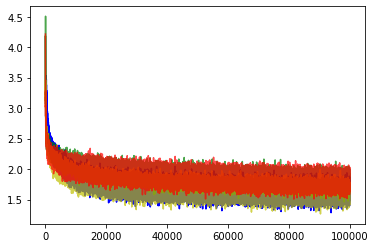

In [ ]:
plt.plot(rnn_h_shakespeare.history_loss,'b')
plt.plot(rnn_h_shakespeare_adagrad.history_loss, 'g', alpha=0.7)
plt.plot(rnn_h_shakespeare_Xavier.history_loss, 'y', alpha=0.7)
plt.plot(rnn_h_shakespeare_Xavier_adagrad.history_loss, 'r', alpha=0.7)

### 5.6. 비교

#### 5.6.1. Accurancy (Charcter)
Initial h_0를 학습시킨 경우 성능이 미미하게 안 좋다. Adagrad로 학습하지 않은 모델의 경우 그런 경향이 더 크다.

In [ ]:
test_size = 4000

print("Basic : ", test(rnn_shakespeare, X_test[:test_size], Y_test[:test_size], 65))
print("Xavier : ", test(rnn_shakespeare_Xavier, X_test[:test_size], Y_test[:test_size], 65))
print("adagrad : ", test(rnn_shakespeare_adagrad, X_test[:test_size], Y_test[:test_size], 65))
print("Xavier + adagrad : ", test(rnn_shakespeare_Xavier_adagrad, X_test[:test_size], Y_test[:test_size], 65))

print("\n Basic : ", test(rnn_h_shakespeare, X_test[:test_size], Y_test[:test_size], 65))
print("Xavier : ", test(rnn_h_shakespeare_Xavier, X_test[:test_size], Y_test[:test_size], 65))
print("adagrad : ", test(rnn_h_shakespeare_adagrad, X_test[:test_size], Y_test[:test_size], 65))
print("Xavier + adagrad : ", test(rnn_h_shakespeare_Xavier_adagrad, X_test[:test_size], Y_test[:test_size], 65))

Basic :  0.5125
Xavier :  0.51725
adagrad :  0.45825
Xavier + adagrad :  0.46175

 Basic :  0.5085
Xavier :  0.51275
adagrad :  0.462
Xavier + adagrad :  0.457


#### 5.6.2. L1 Distance
Initial h_0를 학습시킨 경우 성능이 미미하게 안 좋다. Adagrad로 학습하지 않은 모델의 경우 그런 경향이 더 크다.

In [ ]:
print("Text : ", text_word)
print("Basic : ", rnn_shakespeare_L1, rnn_shakespeare_word)
print("Xavier : ", rnn_shakespeare_Xavier_L1, rnn_shakespeare_Xavier_word)
print("adagrad : ", rnn_shakespeare_adagrad_L1, rnn_shakespeare_adagrad_word)
print("Xavier + adagrad : ", rnn_shakespeare_Xavier_adagrad_L1, rnn_shakespeare_Xavier_adagrad_word)

print("Basic : ", rnn_h_shakespeare_L1, rnn_h_shakespeare_word)
print("Xavier : ", rnn_h_shakespeare_Xavier_L1, rnn_h_shakespeare_Xavier_word)
print("adagrad : ", rnn_h_shakespeare_adagrad_L1, rnn_h_shakespeare_adagrad_word)
print("Xavier + adagrad : ", rnn_h_shakespeare_Xavier_adagrad_L1, rnn_h_shakespeare_Xavier_adagrad_word)

Text :  Counter({'the': 1493, 'I': 1435, 'to': 1130, 'and': 1063, 'a': 900, 'you': 844, 'of': 831, 'my': 674, 'in': 600, 'your': 558, 'is': 556, 'not': 510, 'that': 489, 'be': 470, 'And': 452, 'it': 435, 'with': 427, 'for': 417, 'have': 413, 'as': 348, 'he': 334, 'me': 332, 'this': 331, 'his': 329, 'but': 292, 'thou': 279, 'will': 261, 'her': 259, 'so': 240, 'him': 232, 'VINCENTIO:': 216, 'all': 213, 'shall': 211, 'To': 211, 'by': 201, 'she': 195, 'DUKE': 193, 'are': 190, 'do': 187, 'thy': 184, 'no': 183, 'The': 180, 'if': 174, 'good': 169, 'we': 166, 'That': 159, 'what': 159, 'PETRUCHIO:': 158, 'am': 155, 'But': 153, 'sir,': 153, 'you,': 148, 'would': 146, 'or': 141, 'at': 140, 'was': 136, 'on': 135, 'our': 132, 'from': 129, 'ISABELLA:': 129, 'more': 127, 'know': 123, "I'll": 121, 'As': 120, 'For': 118, 'may': 117, 'A': 112, 'LUCIO:': 111, 'make': 105, 'thee': 104, 'an': 104, 'hath': 104, 'You': 102, 'What': 102, 'must': 101, 'My': 98, 'let': 97, 'If': 94, 'were': 94, 'come': 92, 'one

## 6. 기타

### 6.1. 구현에서 주의할 부분

### 6.2. PyTorch
인턴이의 numpy 탈출기<br>
디버깅 일주일 내내 하는 시절은 이제 안녕

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
tensor_X = torch.tensor(t2i[:-1])
tensor_Y = torch.tensor(t2i[1:])

print(tensor_X[:20])
print(tensor_Y[:20])

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56])
tensor([47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44, 53,
        56, 43])


In [ ]:
class TORCH_RNN(nn.Module):

    def __init__(self, vocab_size, hidden_size):

        super(TORCH_RNN, self).__init__()

        self.rnn = nn.RNN(input_size = vocab_size, hidden_size = hidden_size)
        self.linear
        self.softmax = nn.Softmax(dim = -1)
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size

    def forward(self, X_batch_one_hot_encoding, h = None):

        y_cache, h_cache = self.rnn.forward(X_batch_one_hot_encoding, h)

        return y_cache, h_cache

history_loss = []

def train(X, Y, vocab_size=65, hidden_size=130, epoch = 100000, show = False):

    torch_rnn = TORCH_RNN (vocab_size, hidden_size)
    
    CELoss = nn.CrossEntropyLoss()
    optimizer = optim.SGD(torch_rnn.parameters(), lr=0.01)

    for i in range(epoch):

        seq_length = min(30, max(1, X.shape[0] // 2))
        batch_size = min(16, X.shape[0])

        batch_indice = torch.randint(0, X.shape[0] - seq_length, (batch_size,))
        X_batch = [X[i:i+seq_length] for i in batch_indice]
        Y_batch = [Y[i:i+seq_length] for i in batch_indice]

        X_batch_one_hot_encoding = torch.zeros((seq_length, batch_size, 65))
        X_batch_one_hot_encoding[torch.arange(seq_length * batch_size) // batch_size, torch.arange(seq_length * batch_size) % batch_size, np.array(X_batch).reshape(-1).reshape(-1)] = 1

        y, h = torch_rnn(X)
        y = softmax(y)
        print(y.shape)
        print(Y_batch.T.shape)
        loss = CELoss(y, Y_batch.T)
        history_loss.append(loss.data[0])
        loss.backward()
        optimizer.step()

        if show == True and i % 1000 == 999:
            print(history_loss[-1])

torch_rnn = TORCH_RNN(65, 130)
train(X[:800000], Y[:80000])

TypeError: 'int' object is not callable